In [4]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity


In [5]:
anime_df = pd.read_csv('anime.csv') 
ratings_df = pd.read_csv('rating.csv')

In [6]:
# Handle missing values in anime dataset
anime_df.dropna(inplace=True)

# Handle missing values in ratings dataset (e.g., removing rows with missing user_id or anime_id)
ratings_df.dropna(subset=['user_id', 'anime_id'], inplace=True)

# Replace 'Unknown' values with NaN in anime_df
anime_df.replace('Unknown', pd.NA, inplace=True)

# Drop rows with missing values in anime_df after replacing 'Unknown'
anime_df.dropna(inplace=True)

# Drop duplicate entries in ratings_df
ratings_df.drop_duplicates(inplace=True)

In [7]:
ratings_df = pd.merge(ratings_df, anime_df[['anime_id', 'name', 'genre', 'type']], on='anime_id', how='inner')

In [8]:
# Number of users
print('The ratings dataset has', ratings_df['user_id'].nunique(), 'unique users')

# Number of animes
print('The ratings dataset has', ratings_df['name'].nunique(), 'unique products')

# Number of ratings
print('The ratings dataset has', ratings_df['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings_df['rating'].unique()))

The ratings dataset has 73515 unique users
The ratings dataset has 11157 unique products
The ratings dataset has 11 unique ratings
The unique ratings are [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [9]:
# Count the number of ratings with a value of -1
negative_ratings_count = ratings_df[ratings_df['rating'] == -1].shape[0]
print(f'Number of ratings with -1: {negative_ratings_count}')


Number of ratings with -1: 1476463


In [10]:
# Assuming ratings_df is your DataFrame containing ratings
ratings_df = ratings_df[ratings_df['rating'] != -1]
ratings_df.shape
ratings_df.head(10)

,user_id,anime_id,rating,name,genre,type
47,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV
81,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV
83,1,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV
101,1,15451,10,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV
153,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV
156,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV
157,3,154,6,Shaman King,"Action, Adventure, Comedy, Drama, Shounen, Sup...",TV
158,3,170,9,Slam Dunk,"Comedy, Drama, School, Shounen, Sports",TV
159,3,199,10,Sen to Chihiro no Kamikakushi,"Adventure, Drama, Supernatural",Movie
160,3,225,9,Dragon Ball GT,"Action, Adventure, Comedy, Fantasy, Magic, Sci...",TV


In [11]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6337143 entries, 47 to 7813605
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   int64 
 1   anime_id  int64 
 2   rating    int64 
 3   name      object
 4   genre     object
 5   type      object
dtypes: int64(3), object(3)
memory usage: 338.4+ MB


In [12]:
ratings_df['user_id'].value_counts().head(20)


user_id
42635    3747
53698    2905
57620    2689
59643    2632
51693    2620
45659    2462
7345     2429
12431    2329
65840    2215
22434    1990
51270    1835
65836    1825
49662    1814
30597    1801
11536    1793
23247    1781
40273    1780
30565    1777
13954    1736
59406    1723
Name: count, dtype: int64

In [13]:
# Group by 'user_id' and 'anime_id' and count the occurrences
user_anime_counts = ratings_df.groupby(['user_id', 'anime_id']).size().reset_index(name='count')

# Display the result
print(user_anime_counts)

# If you want to filter and display users who rated the same anime more than once
multiple_ratings = user_anime_counts[user_anime_counts['count'] > 1]
print(multiple_ratings)


         user_id  anime_id  count
0              1      8074      1
1              1     11617      1
2              1     11757      1
3              1     15451      1
4              2     11771      1
...          ...       ...    ...
6337132    73515     16512      1
6337133    73515     17187      1
6337134    73515     22145      1
6337135    73516       790      1
6337136    73516      8074      1

[6337137 rows x 3 columns]
         user_id  anime_id  count
3637082    42653      1575      2
3637084    42653      2001      2
3637113    42653     11757      2
3637130    42653     20507      2
3637136    42653     22319      2
3637139    42653     23283      2


In [14]:
# Drop duplicate ratings, keeping only the first occurrence
ratings_df = ratings_df.drop_duplicates(subset=['user_id', 'anime_id'], keep='first')
ratings_df.shape
# Display the result

(6337137, 6)

In [15]:
# Group by 'user_id' and count the number of ratings for each user
user_ratings_count = ratings_df.groupby('user_id').size().reset_index(name='ratings_count')

# Filter users with more than 600 ratings
filtered_user_ids = user_ratings_count[user_ratings_count['ratings_count'] <= 500]['user_id'].tolist()

# Filter the ratings_df based on the filtered_user_ids
filtered_ratings_df = ratings_df[ratings_df['user_id'].isin(filtered_user_ids)]

In [16]:
filtered_ratings_df.shape

(5338378, 6)

In [17]:
filtered_ratings_df.head(100)

,user_id,anime_id,rating,name,genre,type
47,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV
81,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV
83,1,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV
101,1,15451,10,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV
153,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV
...,...,...,...,...,...,...
248,3,31043,10,Boku dake ga Inai Machi,"Mystery, Psychological, Seinen, Supernatural",TV
249,3,31859,7,Hai to Gensou no Grimgar,"Action, Adventure, Drama, Fantasy",TV
302,5,6,8,Trigun,"Action, Comedy, Sci-Fi",TV
303,5,15,6,Eyeshield 21,"Action, Comedy, Shounen, Sports",TV


In [18]:
ratings_df=filtered_ratings_df
ratings_df.shape

(5338378, 6)

In [19]:
# Group by 'anime_id' and count the number of unique users who rated each anime
anime_user_count = ratings_df.groupby('anime_id')['user_id'].nunique().reset_index(name='user_count')

# Filter animes rated by more than 15 users
filtered_anime_ids = anime_user_count[anime_user_count['user_count'] > 15]['anime_id'].tolist()

# Filter the ratings_df based on the filtered_anime_ids
filtered_ratings_df = ratings_df[ratings_df['anime_id'].isin(filtered_anime_ids)]


In [20]:
filtered_ratings_df.info

<bound method DataFrame.info of          user_id  anime_id  rating  \
47             1      8074      10   
81             1     11617      10   
83             1     11757      10   
101            1     15451      10   
153            2     11771      10   
...          ...       ...     ...   
7813601    73515     16512       7   
7813602    73515     17187       9   
7813603    73515     22145      10   
7813604    73516       790       9   
7813605    73516      8074       9   

                                                    name  \
47                                Highschool of the Dead   
81                                       High School DxD   
83                                      Sword Art Online   
101                                  High School DxD New   
153                                     Kuroko no Basket   
...                                                  ...   
7813601                   Devil Survivor 2 The Animation   
7813602  Ghost in the Shell: Ar

In [21]:
filtered_ratings_df.groupby('anime_id')['user_id'].nunique().reset_index(name='user_count').head(10)

,anime_id,user_count
0,1,12609
1,5,5227
2,6,8667
3,7,1845
4,8,232
5,15,1738
6,16,2823
7,17,448
8,18,1284
9,19,3668


In [22]:
ratings_df=filtered_ratings_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5923 entries, 0 to 5922
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               5923 non-null   object 
 1   mean_rating        5923 non-null   float64
 2   number_of_ratings  5923 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 138.9+ KB


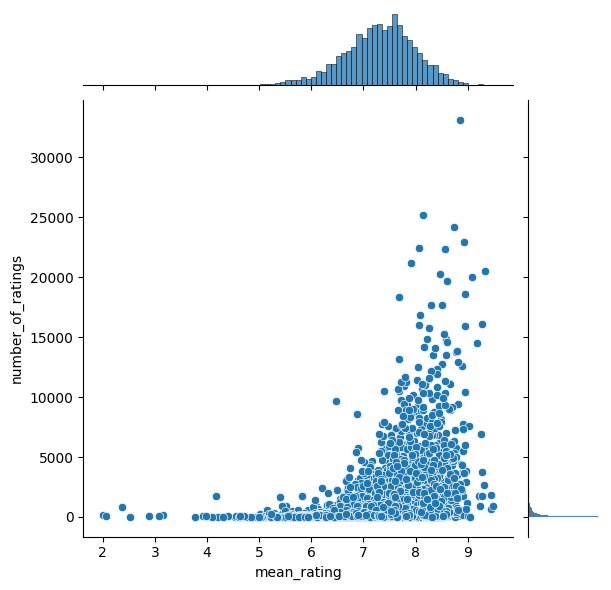

In [23]:
agg_ratings = ratings_df.groupby('name').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()


# Visulization
#sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings)
agg_ratings = agg_ratings[agg_ratings['number_of_ratings'] >15]
agg_ratings.info()

# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings)

In [24]:
agg_ratings = agg_ratings.sort_values(by='number_of_ratings', ascending=False)
agg_ratings.head()

,name,mean_rating,number_of_ratings
1059,Death Note,8.843596,33113
5072,Sword Art Online,8.147329,25175
4746,Shingeki no Kyojin,8.733765,24223
889,Code Geass: Hangyaku no Lelouch,8.934126,22968
1361,Elfen Lied,8.071005,22421


In [25]:
# Number of users
print('The ratings dataset has', ratings_df['user_id'].nunique(), 'unique users')

# Number of animes
print('The ratings dataset has', ratings_df['name'].nunique(), 'unique products')

# Number of ratings
print('The ratings dataset has', ratings_df['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings_df['rating'].unique()))

The ratings dataset has 68236 unique users
The ratings dataset has 5923 unique products
The ratings dataset has 10 unique ratings
The unique ratings are [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [26]:
anime_pivot= ratings_df.pivot_table(columns='user_id', index='name', values='rating')

In [27]:
anime_pivot

user_id,1,2,3,5,7,8,9,10,11,12,...,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
&quot;Bungaku Shoujo&quot; Memoire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
&quot;Bungaku Shoujo&quot; Movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
.hack//G.U. Returner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
.hack//G.U. Trilogy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xxxHOLiC,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xxxHOLiC Kei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xxxHOLiC Movie: Manatsu no Yoru no Yume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
anime_pivot.fillna(0, inplace=True)

In [29]:
anime_pivot

user_id,1,2,3,5,7,8,9,10,11,12,...,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Returner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xxxHOLiC,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xxxHOLiC Kei,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xxxHOLiC Movie: Manatsu no Yoru no Yume,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
from scipy.sparse import csr_matrix

In [31]:
anime_sparse= csr_matrix(anime_pivot)

In [32]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(algorithm='brute')

In [33]:
model.fit(anime_sparse)

NearestNeighbors(algorithm='brute')

In [34]:
distance, suggestion= model.kneighbors(anime_pivot.iloc[1, :].values.reshape(1, -1), n_neighbors=10 )

In [35]:
distance

array([[  0.        , 136.25710991, 158.23400393, 158.63795258,
        158.71987903, 158.78601954, 158.94653189, 159.02515524,
        159.06288065, 159.06602403]])

In [36]:
suggestion

array([[   1,    0, 4009, 3773, 5346, 2738,  702, 1051,  250, 4381]],
      dtype=int64)

In [37]:
for i in range(len(suggestion)):
    print (anime_pivot.index[suggestion[i]] )

Index(['&quot;Bungaku Shoujo&quot; Memoire',
       '&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi', 'Panzer Dragoon',
       'Nougyou Musume!', 'Tokyo Daigaku Monogatari', 'Kobe to Watashi',
       'CCW: Crazy Clay Wrestling', 'De:vadasy', 'Anime Oyako Gekijou',
       'Roots Search: Shokushin Buttai X'],
      dtype='object', name='name')


In [38]:
anime_pivot.index[3]

'.hack//G.U. Returner'

In [39]:
anime_name = anime_pivot.index

In [40]:

import pickle
pickle.dump(model, open('artifacts/model.pkl', 'wb' ) )
pickle.dump(anime_name, open( 'artifacts/anime_name.pkl','wb'))
pickle.dump(ratings_df, open( 'artifacts/final_rating.pkl','wb'))
pickle.dump(anime_pivot, open( 'artifacts/anime_pivot.pkl','wb'))

In [41]:
def recommend_anime(anime_name):
    anime_id =np.where(anime_pivot.index==anime_name)[0][0]
    distance, suggestion= model.kneighbors(anime_pivot.iloc[anime_id, :].values.reshape(1, -1), n_neighbors=50)
    for i in range(len(suggestion)):
        animes=anime_pivot.index[suggestion[i]] 
        for j in animes:
            print(j)

In [42]:
x= 'Dragon Ball'
recommend_anime(x)

Dragon Ball
Dragon Ball GT
Dragon Ball Z
Dragon Ball Z Movie 01: Ora no Gohan wo Kaese!!
Dragon Ball Z Movie 08: Moetsukiro!! Nessen, Ressen, Chougekisen
Dragon Ball Z Movie 05: Tobikkiri no Saikyou tai Saikyou
Dragon Ball Z Movie 03: Chikyuu Marugoto Choukessen
Dragon Ball Z Movie 06: Gekitotsu!! 100-oku Power no Senshi-tachi
Dragon Ball Z Movie 02: Kono Yo de Ichiban Tsuyoi Yatsu
Dragon Ball Z Movie 04: Super Saiyajin da Son Gokuu
Dragon Ball Z Movie 07: Kyokugen Battle!! Sandai Super Saiyajin
Dragon Ball Z Movie 10: Kiken na Futari! Super Senshi wa Nemurenai
Dragon Ball Kai
Dragon Ball Z Movie 09: Ginga Girigiri!! Bucchigiri no Sugoi Yatsu
Dragon Ball Z Movie 12: Fukkatsu no Fusion!! Gokuu to Vegeta
Dragon Ball Z Movie 11: Super Senshi Gekiha!! Katsu no wa Ore da
Dragon Ball Z Movie 13: Ryuuken Bakuhatsu!! Goku ga Yaraneba Dare ga Yaru
Dragon Ball Movie 1: Shen Long no Densetsu
Dragon Ball Z Special 1: Tatta Hitori no Saishuu Kessen
Dragon Ball Z Special 2: Zetsubou e no Hankou!! No

In [44]:
x= 'Naruto'
recommend_anime(x)

Naruto
Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!
Naruto: Shippuuden Movie 1
Naruto Movie 2: Dai Gekitotsu! Maboroshi no Chiteiiseki Dattebayo!
Naruto: Shippuuden Movie 2 - Kizuna
Naruto Movie 3: Dai Koufun! Mikazuki Jima no Animaru Panikku Dattebayo!
Bleach
Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono
Naruto: Shippuuden Movie 4 - The Lost Tower
Dragon Ball GT
Naruto: Shippuuden Movie 6 - Road to Ninja
Naruto: Shippuuden Movie 5 - Blood Prison
Naruto: Takigakure no Shitou - Ore ga Eiyuu Dattebayo!
Naruto: Akaki Yotsuba no Clover wo Sagase
Naruto: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo! Special: Konoha Annual Sports Festival
Naruto Narutimate Hero 3: Tsuini Gekitotsu! Jounin vs. Genin!! Musabetsu Dairansen taikai Kaisai!!
Bleach Movie 1: Memories of Nobody
Bleach Movie 2: The DiamondDust Rebellion - Mou Hitotsu no Hyourinmaru
Dragon Ball
The Last: Naruto the Movie
Shaman King
Bleach Movie 3: Fade to Black - Kimi no Na wo Yobu
Naruto Shippuud